In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from lifetimes.utils import *
from lifetimes import BetaGeoFitter,GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix, plot_period_transactions, plot_cumulative_transactions,plot_incremental_transactions
from lifetimes.generate_data import beta_geometric_nbd_model
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions,plot_history_alive

orders = pd.read_csv('C:/Sahil Files/IIT Delhi/Second Semester/Major Project/archive/olist_orders_dataset.csv')
items = pd.read_csv('C:/Sahil Files/IIT Delhi/Second Semester/Major Project/archive/olist_order_items_dataset.csv')
cust = pd.read_csv('C:/Sahil Files/IIT Delhi/Second Semester/Major Project/archive/olist_customers_dataset.csv')

### Refine

In [2]:
cust.groupby('customer_unique_id').size().value_counts()

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
17        1
9         1
dtype: int64

In [3]:
orders = pd.merge(orders,cust[['customer_id','customer_unique_id']],on='customer_id')
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6


In [4]:
print(items.columns)
items.drop_duplicates('order_id',keep='first',inplace=True)

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')


In [5]:
transaction_data = pd.merge(orders,items,'inner','order_id')
transaction_data = transaction_data[['customer_unique_id','order_purchase_timestamp','price']]

## convert timestamp to date; only need the day
transaction_data['date'] = pd.to_datetime(transaction_data['order_purchase_timestamp']).dt.date
transaction_data = transaction_data.drop('order_purchase_timestamp',axis=1)
transaction_data.head()

,customer_unique_id,price,date
0,7c396fd4830fd04220f754e42b4e5bff,29.99,2017-10-02
1,af07308b275d755c9edb36a90c618231,118.70,2018-07-24
2,3a653a41f6f9fc3d2a113cf8398680e8,159.90,2018-08-08
3,7c142cf63193a1473d2e66489a9ae977,45.00,2017-11-18
4,72632f0f9dd73dfee390c9b22eb56dd6,19.90,2018-02-13


Now that I have my transaction data, I want to convert this into dataframe with the RFM variables that I mentioned in the introduction. The Lifetimes package has a function for converting transaction data into an RFM DataFrame. 

In [6]:
summary = summary_data_from_transaction_data(transaction_data,'customer_unique_id','date',monetary_value_col='price',)
summary.describe()

,frequency,recency,T,monetary_value
count,95420.000000,95420.000000,95420.000000,95420.000000
mean,0.024198,2.683389,246.184846,2.474897
std,0.178936,25.263074,153.656402,26.579606
min,0.000000,0.000000,5.000000,0.000000
25%,0.000000,0.000000,122.000000,0.000000
50%,0.000000,0.000000,227.000000,0.000000
75%,0.000000,0.000000,356.000000,0.000000
max,15.000000,633.000000,729.000000,1999.990000


### Final Raw Values

In [7]:
summary[summary['frequency']>0].head()

,frequency,recency,T,monetary_value
customer_unique_id,,,,
004288347e5e88a27ded2bb23747066c,1.0,171.0,403.0,87.90
004b45ec5c64187465168251cd1c9c2f,1.0,267.0,367.0,27.00
0058f300f57d7b93c477a131a59b36c3,1.0,31.0,196.0,72.58
00a39521eb40f7012db50455bf083460,1.0,11.0,103.0,11.55
011575986092c30523ecb71ff10cb473,1.0,60.0,198.0,63.90


In [8]:
summary['frequency'].value_counts()

0.0     93335
1.0      1927
2.0       126
3.0        18
4.0         6
5.0         5
6.0         2
15.0        1
Name: frequency, dtype: int64

In [10]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 95420 subjects, a: 2.07, alpha: 65.86, b: 0.35, r: 0.02>

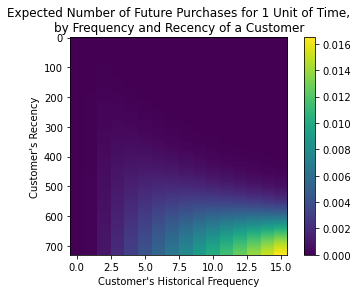

In [11]:
plot_frequency_recency_matrix(bgf); 

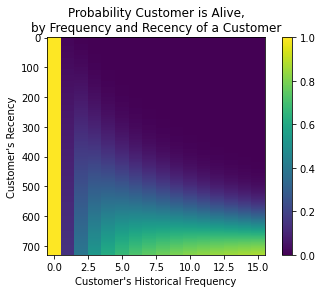

In [12]:
plot_probability_alive_matrix(bgf);

#### 1) Calibration period histogram

C:\Users\sahil\anaconda3\lib\site-packages\lifetimes\generate_data.py:54: RuntimeWarning: overflow encountered in double_scalars
  next_purchase_in = random.exponential(scale=1.0 / l)


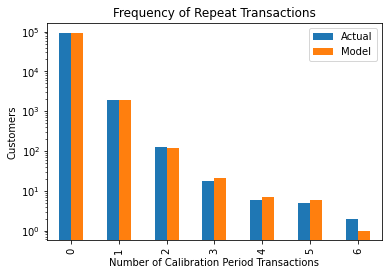

In [13]:
plot_period_transactions(bgf).set_yscale('log');

The model is fairly representative of the real data up until four repeat transactions. There are few customers who make more purchases.

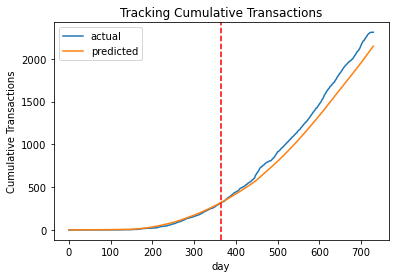

In [15]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_cumulative_transactions(bgf,transaction_data,'date','customer_unique_id',730,365);

The red line represents the boundary between the calibration period on the left and the holdout period on the right. As you can see, the BG/NBD model does a pretty swell job at predicting cumulative transactions.

This plot shows that the model does a decent job capturing general trends in the data. 

### Modeling churn risk

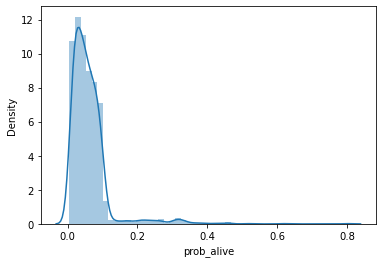

In [23]:
df = summary[summary['frequency']>0]
df['prob_alive'] = bgf.conditional_probability_alive(df['frequency'],df['recency'],df['T'])
sns.distplot(df['prob_alive']);

In [76]:
high_risk_customer = df[(df.prob_alive>=.1) & (df.prob_alive<.3)]
print("high_risk_customer",len(high_risk_customer))
active_customers = df[(df['prob_alive']>=.3)]
print("active_customer",len(active_customers))
churn_customers = df[(df.prob_alive<.1)]
print("churn_customer",len(churn_customers))

high_risk_customer 120
active_customer 37
churn_customer 1928


In [48]:
high_risk_customer = df[(df.prob_alive>0.1) & (df.prob_alive<0.3)]
high_risk_customer.sort_values(by="prob_alive", ascending = False)

,frequency,recency,T,monetary_value,prob_alive
customer_unique_id,,,,,
6a6a7141119ceaeca4dfbae7a580a515,2.0,307.0,353.0,19.300000,0.297275
9689908caf4de73724feed92175d867a,2.0,162.0,193.0,98.995000,0.289482
ca77025e7201e3b30c44b472ff346268,6.0,235.0,329.0,66.126667,0.275447
96f9204de777192f8feb7776d3cd09b4,2.0,86.0,111.0,99.900000,0.273597
bc3e7032668d3f411c227eec09221362,2.0,59.0,80.0,55.000000,0.268846
...,...,...,...,...,...
cd915c60db8686f9a3dc35745aa1691c,1.0,254.0,273.0,64.900000,0.100719
78d79858662c99b94b69547d9f80e061,1.0,201.0,217.0,129.900000,0.100562
46da36c3df7118852b770394d1ba2be5,1.0,408.0,438.0,52.900000,0.100526
